<b>Connection to Postgres</b>

In [1]:
import psycopg2
import matplotlib.pyplot as plt
from tabulate import tabulate
from numpy import array
%matplotlib inline

hostname = 'localhost'
database = 'postgres'
username = 'postgres'
pwd = '8424'
port_id = 5432
cur = None
conn = psycopg2.connect(
            host=hostname,
            dbname=database,
            user=username,
            password=pwd,
            port=port_id)

conn.autocommit = True

__Verfying connection to Postgres__

In [2]:

conn = psycopg2.connect(dbname="postgres",
                        user="postgres",
                        host="localhost",
                        password="8424",
                        port="5432")

cursor = conn.cursor()
cursor.execute("SELECT * FROM information_schema.tables where table_schema = 'dbms'")
rows = cursor.fetchall()
for table in rows:
    print(table)


('postgres', 'dbms', 'artists', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'session', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'music_stream', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'genrerel', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'genre', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'songs', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)
('postgres', 'dbms', 'users', 'BASE TABLE', None, None, None, None, None, 'YES', 'NO', None)


<p>List out the number of sessions,subscribers are present in based on their subscription_type</p>


In [3]:

columns = ["subscription_type", "user_count"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select u.subscription_type ,count(session_id) as user_count 
                    from dbms.users u 
                    JOIN dbms.music_stream ms 
                    ON u.user_id = ms.subscriber 
                    GROUP BY u.subscription_type 
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,2):
    data.append(rows[i])

print(tabulate(data,columns)) 


Total number of rows returned:2
subscription_type      user_count
-------------------  ------------
Free                           71
Premium                        79


<p>In which year or years were the most songs recorded and how many songs are those?</p>


In [4]:
columns = ["release_year", "num_songs"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select release_year, num_songs from (
                    select release_year, count(title) as num_songs,
                    ROW_NUMBER() over (order by count(title) desc) as row_num
                    from dbms.songs 
                    group by release_year) sngs
                    where row_num = 1; 
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,1):
    data.append(rows[i])

print(tabulate(data,columns))   


Total number of rows returned:1
  release_year    num_songs
--------------  -----------
          2011           20


<p>For songs released in every year, List the number of times all the songs were listened to.</p>

<i>This barchart visualization helps in knowing which year's music is at top. It could help figure out which year has the best songs everyone's listening to.</i> 

Total number of rows returned: 35
  release_year    times_streamed
--------------  ----------------
          1980                39
          1981                53
          1982                29
          1983                41
          1984                20


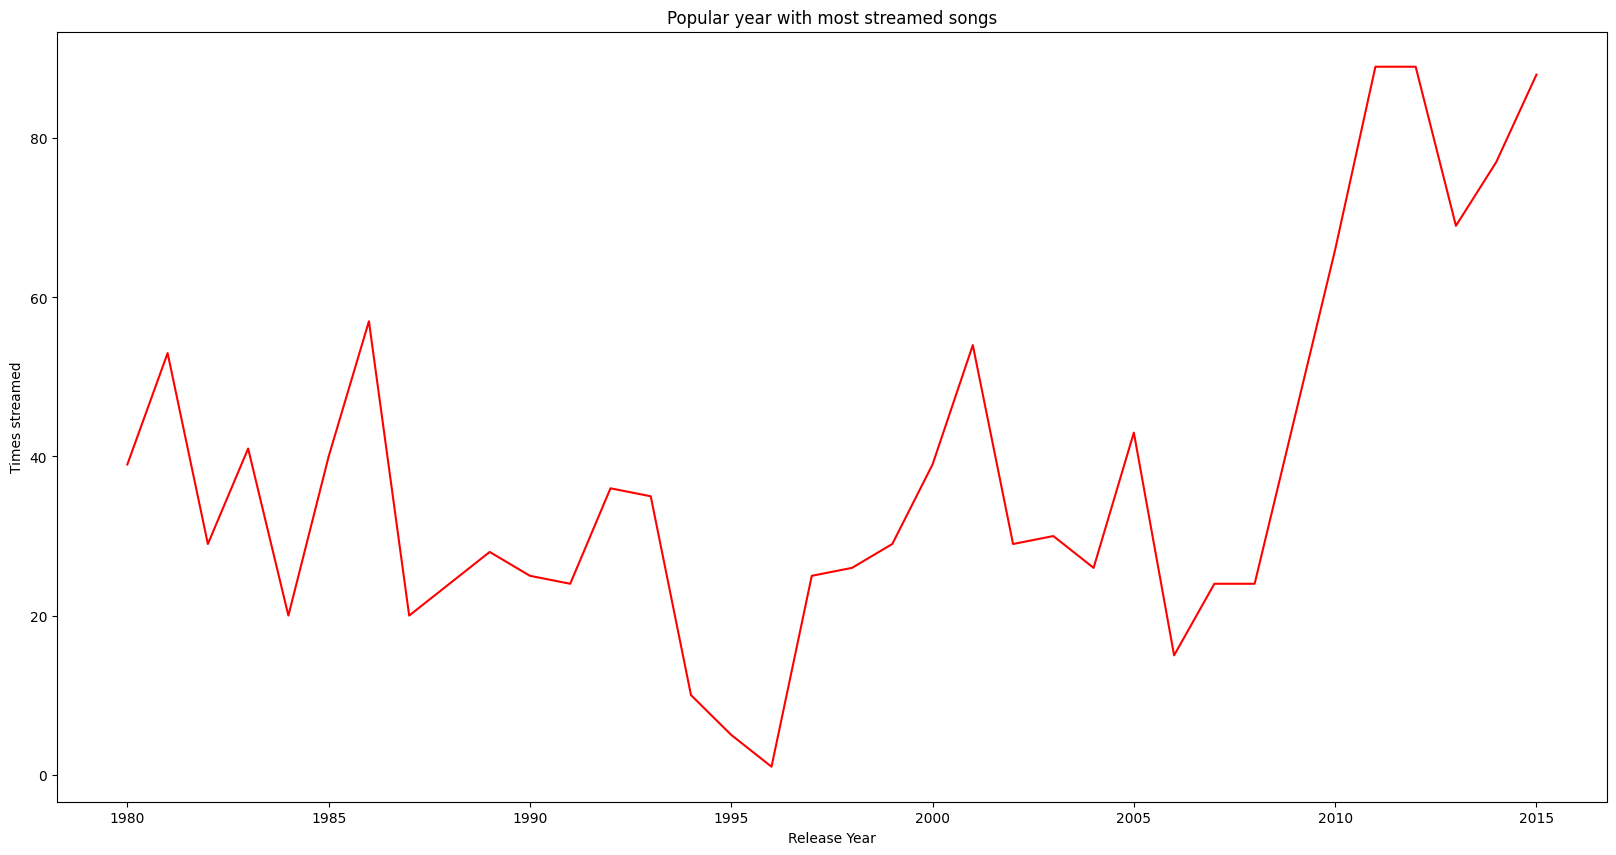

In [5]:
release_year=[]
times_streamed=[]
columns = ["release_year", "times_streamed"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select b.release_year , sum(a.num_lisened_to ) as times_streamed
                    from (
                    select  unnest(songs) as song_id, count(*) as num_lisened_to
                    from dbms.music_stream
                    group by unnest(songs)) a
                    left join (
                    select release_year, song_id  
                    from dbms.songs ) b
                    on a.song_id = b.song_id 
                    group by b.release_year
                    order by  b.release_year 
                """)
rows = cursor.fetchall()
print("Total number of rows returned: " +str(len(rows)))

for i in rows:
    release_year.append(i[0])
    times_streamed.append(i[1])
    
for i in range(0,5):
    data.append((release_year[i],times_streamed[i]))
print(tabulate(data,columns)) 


fig,ax1=plt.subplots(figsize=(20,10))
ax1.plot(release_year, times_streamed, color = "red")
ax1.set_title("Popular year with most streamed songs")
ax1.set_xlabel("Release Year")
ax1.set_ylabel("Times streamed")
plt.show()

<p>Who is the singer that was born in 1991 and sang the most of POP</p>

In [6]:
columns = ["singer","country"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select a.name as singer,a.country from 
                    dbms.artists a
                    where dob::text  like '1991%'
                    and name in 
                    (select distinct artist from  dbms.genrerel where lower(genre) = 'pop') 
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,1):
    data.append(rows[i])

print(tabulate(data,columns))  



Total number of rows returned:1
singer       country
-----------  ---------
The Beatles  Indonesia


<p>List out the song id premium users are listening to that is currently popular?</p>

In [7]:
columns = ["song_id"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select song_id from (
                        select unnest(m.songs) as song_id, count(*) as popularity,
                        dense_rank() over (order by count(*) desc) as rnk
                        from dbms.users u, dbms.music_stream m
                        where u.subscription_type = 'Premium'
                        and  u.user_id = m.subscriber
                        group by unnest(m.songs)) x
                    where rnk = 1 
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,1):
    data.append(rows[i])

print(tabulate(data,columns))  

Total number of rows returned:1
song_id
------------------------------------
f82949af-7230-4f8a-8f68-fd5221d372d0


<p>Name the popular singer(s) for ever year. Popularity will be based on whose song is most listened to in that year.</p>

<i>This visualization identifies the top artists each year.</i>

Total number of rows returned:52
  release_year  singer
--------------  ------------------------
          1980  Nicki Minaj
          1980  The All-American Rejects
          1981  The Police
          1982  The Smiths
          1983  Radiohead


<function matplotlib.pyplot.show(close=None, block=None)>

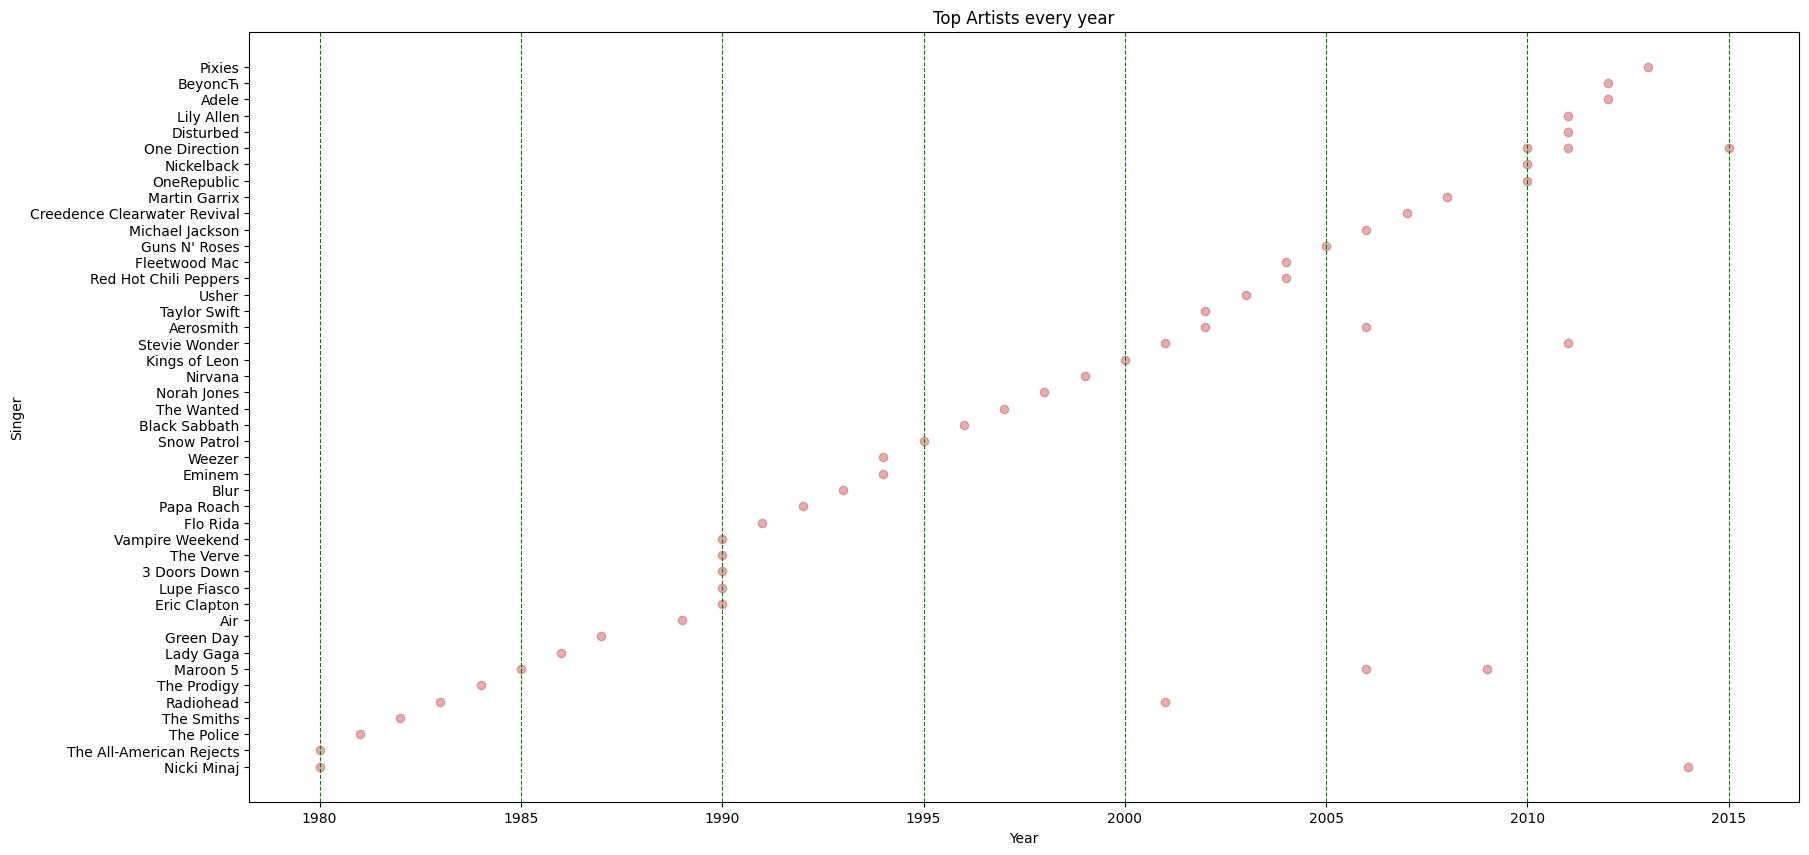

In [8]:
release_year=[]
singer=[]
columns = ["release_year","singer"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    with tmp_tbl as (
                        select s.singer, s.release_year, m.song_id, m.song_popularity
                        from (
                        select singer, song_id, release_year
                        from dbms.songs ) s
                        left join 
                        (select unnest(songs) as song_id, count(subscriber) as song_popularity
                        from dbms.music_stream 
                        group by unnest(songs)) m
                        on s.song_id = m.song_id
                        where m.song_id is not null 
                    )

                    select pop.release_year,sng.singer  from (
                        select release_year, song_id, sum(song_popularity) as tot_popularity,
                        dense_rank() over (partition by release_year order by sum(song_popularity) desc) as rnk
                        from tmp_tbl
                        group by release_year, song_id) pop 
                        left join (select distinct song_id, singer from dbms.songs) sng
                        on pop.song_id = sng.song_id
                    where pop.rnk = 1
                    order by  pop.release_year
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in rows:
    release_year.append(i[0])
    singer.append(i[1])

for i in range(0,5):
    data.append(rows[i])

print(tabulate(data,columns)) 

plt.figure(figsize=(20,10))
plt.scatter(release_year,singer,color='indianred',alpha=0.5)
plt.title("Top Artists every year")
plt.xlabel("Year")
plt.ylabel("Singer")
plt.grid(axis= 'x', color='green',linestyle='--')
plt.show

<p>Which artist has no genre?</p>

In [14]:
columns = ["artist_name"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select distinct a.name as artist_name
                    from dbms.artists a
                    left join  
                    (select distinct artist from dbms.genrerel_2) g 
                    on a.name = g.artist
                    where g.artist is null
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,5):
    data.append(rows[i])

print(tabulate(data,columns))

Total number of rows returned:109
artist_name
-------------------
Drake
Rise Against
Arcade Fire
Death Cab for Cutie
AC/DC


<p>List the 1998-born singers' names, the number of songs they performed, and their overall songs' length.</p>

In [10]:
columns = ["singer","num_songs","duration","dob"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select s.singer , count(*) as num_songs, concat(round(SUM(s.duration):: decimal,2), ' sec') as duration,a.dob
                    from dbms.songs s,dbms.artists a 
                    where dob::text like '1998%'
                    and a.name = s.singer
                    group by  s.singer, a.dob
                    order by duration;
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,5):
    data.append(rows[i])

print(tabulate(data,columns))

Total number of rows returned:13
singer                   num_songs  duration    dob
---------------------  -----------  ----------  ----------
Franz Ferdinand                  1  123.22 sec  1998-03-14
Snoop Dogg                       1  124.86 sec  1998-04-06
blink-182                        1  173.66 sec  1998-10-11
The Smashing Pumpkins            1  186.49 sec  1998-06-25
The Kinks                        1  186.49 sec  1998-06-15


<p>Determine the longest session and identify the user details (name, id, gender) of that session</p>

In [11]:
columns = ["session_id","session_duration","full_name","gender","subscription_type"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    select s.session_id,(s.session_end_time - s.session_start_time) AS session_duration,
                    u.first_name || ' ' || u.last_name AS full_name, u.gender, u.subscription_type
                    from dbms.session s
                    join dbms.music_stream ms on s.session_id = ms.session_id
                    join dbms.users u on ms.subscriber = u.user_id
                    order by session_duration desc 
                    fetch first 1 row only
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))

for i in range(0,1):
    data.append(rows[i])

print(tabulate(data,columns))

Total number of rows returned:1
session_id                            session_duration    full_name         gender    subscription_type
------------------------------------  ------------------  ----------------  --------  -------------------
cb9e0cc3-d52a-43e4-a475-f3dc03c4cdf2  1:40:38             Beatrice Mcnally  Female    Free


<p>How many users of the app and the website are free and premium users</p>

<i>The pie chart will help to visualize the percentage of free and premium users using a Mobile application and Website</i>

Total number of rows returned:2
platform      app_users    web_users
----------  -----------  -----------
Free                 36           35
Premium              32           47


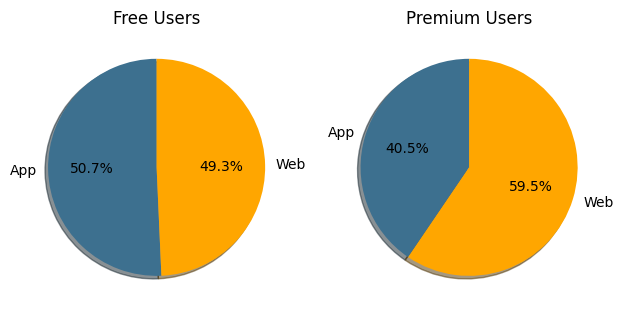

In [12]:
columns = ["platform","app_users","web_users"]
data = []
cursor = conn.cursor()
cursor.execute(f"""
                    with temp_data as (
	                select ses.platform, m.subscriber , u.subscription_type
	                from dbms.session ses, dbms.music_stream m, dbms.users u 
	                where ses.session_id = m.session_id
	                and m.subscriber = u.user_id
	                ) 

	                select subscription_type
					,sum(case when platform = 'App' then 1 else 0 end )as app_users
					,sum(case when platform = 'Web' then 1 else 0 end )as web_users
					from temp_data
					group by subscription_type
                """)
rows = cursor.fetchall()
print("Total number of rows returned:" +str(len(rows)))
    
for i in range(0,2):
    data.append(rows[i])

print(tabulate(data,columns))

plt.subplot(1,2,1)
#fig,ax1 = plt.subplots()
labels=['App','Web'] 
my_colors = ['#3d708f', '#ffa600']
sizes=[36,35]
plt.pie(sizes,labels=labels,autopct = '%1.1f%%',shadow=True,colors=my_colors,startangle=90)
plt.title("Free Users")
plt.show

#fig,ax2 = plt.subplots()
plt.subplot(1,2,2)
labels=['App','Web']
my_colors = ['#3d708f', '#ffa600']
sizes=[32,47]
plt.pie(sizes,labels=labels,autopct = '%1.1f%%',shadow=True, startangle=90,colors=my_colors)
plt.title("Premium Users")
plt.tight_layout()
plt.show
plt.show(block="False")
